In [ ]:
import random
import wandb
from tqdm import tqdm
import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import plotly.express as px


import torch

print(torch.__version__)
print(torch.version.cuda)

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Entities
from torch_geometric.nn import GATConv
from torch_geometric.utils import k_hop_subgraph


import collections
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import plotly.express as px

import seaborn as sns
from functools import partial
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


import collections
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

pl.seed_everything(11)

## 1.1 AFIB dataset

In [ ]:
dataset = Entities(name='AIFB', root='data/aifb')
data = dataset[0]

### Exploration

EDGE TYPES

In [ ]:
data.edge_type.unique()

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89])

In [ ]:
len(data.edge_type.unique())

90

NODE TYPES

In [ ]:
data.node_stores[0].train_y

tensor([2, 1, 3, 3, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 3, 1, 3, 3, 1, 2,
        1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 0, 3, 3, 1, 0, 2, 2, 1, 3, 2, 2, 1, 2,
        0, 2, 0, 2, 1, 1, 2, 1, 1, 1, 2, 2, 3, 3, 1, 2, 2, 1, 1, 3, 2, 2, 1, 3,
        2, 3, 1, 2, 1, 2, 2, 3, 2, 3, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 2, 2, 2,
        3, 1, 3, 3, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 3, 2, 1, 2, 0, 0, 2, 2, 2, 3,
        0, 1, 2, 2, 2, 2, 0, 1, 1, 2, 1, 3, 1, 0, 2, 2, 1, 2, 0, 3])

In [ ]:
data.node_stores[0].test_y

tensor([2, 1, 3, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 3, 0, 1, 1, 2, 1, 1,
        3, 3, 1, 1, 2, 1, 2, 3, 0, 2, 3, 0])

In [ ]:
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of node features: {data.num_node_features}')
print(f'Number of edge features: {data.num_edge_features}')
print(f'Number of edge types: {len(data.edge_type.unique())}')

print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

print(f'Average node degree: {(data.num_edges) / data.num_nodes:.2f}')

Number of nodes: 8285
Number of edges: 58086
Number of classes: 4
Number of node features: 0
Number of edge features: 0
Number of edge types: 90
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True
Average node degree: 7.01


Careful! As we can have multiple relations between the same two nodes, we would need a MultiDiGraph and not a DiGraph.

We will lose edges by transforming to networkx! But for plotting purposes, it is fine.

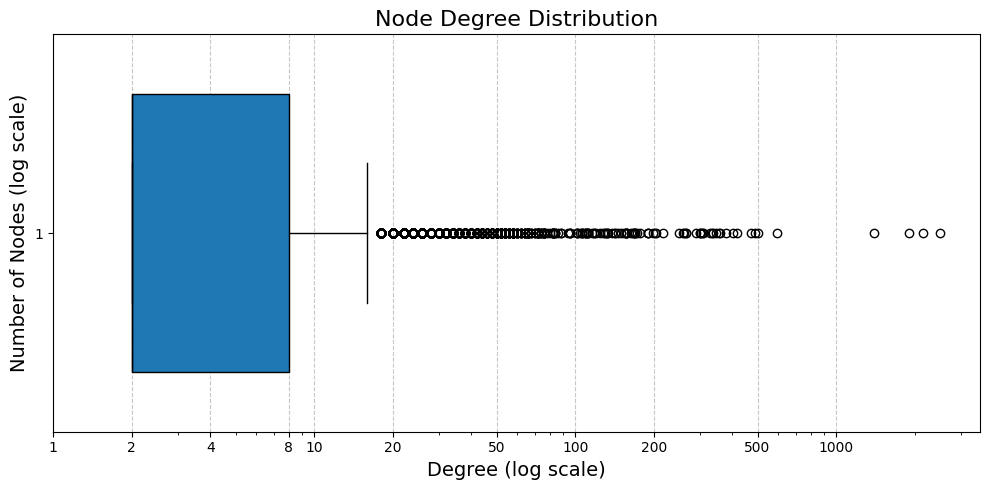

In [ ]:
G = to_networkx(data, to_undirected=False, edge_attrs=['edge_type'])
# Distribution
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

degree_count = collections.Counter(degree_sequence)
deg, cnt = zip(*degree_count.items())


# Define custom bin edges
bins = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 400, 500, 1000, 1200]

# Create the boxplot with log scale on both axes
plt.figure(figsize=(10, 5))
plt.boxplot(degree_sequence, vert=False, widths=0.7, patch_artist=True, medianprops={'color': 'black'})
plt.xscale('log')  # Add log scale to the x-axis

# Manually set x-axis ticks and labels
tick_positions = [1, 2, 4, 8, 10, 20, 50, 100, 200, 500, 1000]
tick_labels = [str(tick) for tick in tick_positions]
plt.xticks(tick_positions, tick_labels)


plt.xlabel("Degree (log scale)", fontsize=14)
plt.ylabel("Number of Nodes (log scale)", fontsize=14)
plt.title("Node Degree Distribution", fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
connected_components = list(nx.connected_components(G))

# Calculate the diameter for each connected component
for i, component in enumerate(connected_components):
    subgraph = G.subgraph(component)
    diameter = nx.diameter(subgraph, e=None, usebounds=False)
    print(f'Connected Component {i + 1} Diameter: {diameter}')

Connected Component 1 Diameter: 8
Connected Component 2 Diameter: 1


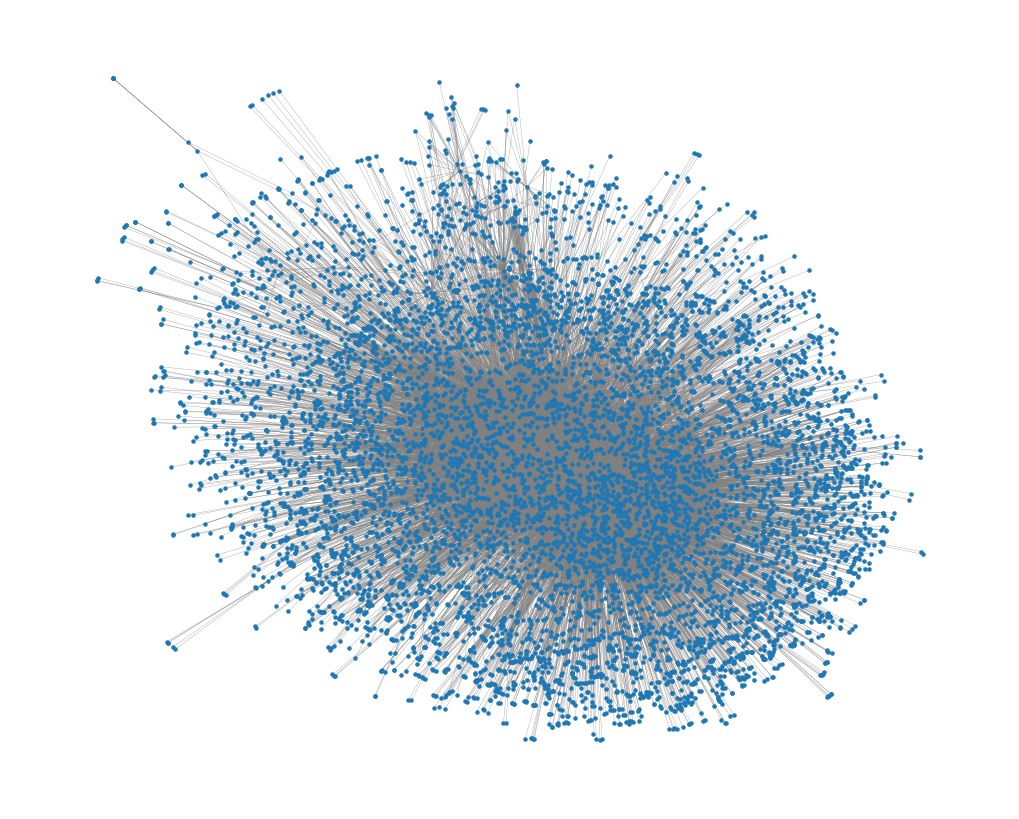

In [ ]:
connected_components = list(nx.connected_components(G))
subgraph = G.subgraph(connected_components[0])

pos = nx.spring_layout(subgraph)

plt.figure(figsize=(10, 8))
nx.draw(subgraph, pos, with_labels=False, node_size=5, width=0.2, edge_color='grey')
plt.show()

### Random Prediction

In [ ]:
edge_types = set()
for i in range(data.edge_index.shape[1]):
    edge_type = data.edge_type[i].detach().numpy().item(0)
    edge_types.add(edge_type)

In [ ]:
def predict(node):
    return np.random.choice([*edge_types])

In [ ]:
acc = []
for i in range(3):
  correct = (data.test_y.numpy() == (np.array([predict(y) for y in dataset.data.test_idx]))).sum()

  acc.append(correct / len(dataset.data.test_idx))

(np.mean(acc), np.std(acc))

### Node Predicion baseline using self made features

In [ ]:
features = np.zeros((data.num_nodes, 2 * data.num_edge_types))

for i in range(data.edge_index.shape[1]):
    src = data.edge_index[0][i].detach().numpy().item(0)
    dst = data.edge_index[1][i].detach().numpy().item(0)
    edge_type = data.edge_type[i].detach().numpy().item(0)

    features[src][edge_type] += 1
    features[dst][edge_type + data.num_edge_types] += 1

In [ ]:
# Calculate the source, destination, and edge type arrays
src = data.edge_index[0].detach().numpy()
dst = data.edge_index[1].detach().numpy()
edge_type = data.edge_type.detach().numpy()

# Initialize the featuresAM matrix
features2 = np.zeros((data.num_nodes, 2 * data.num_edge_types))

# Increment the featuresAM matrix using numpy operations
np.add.at(features2, (src, edge_type), 1)
np.add.at(features2, (dst, edge_type + data.num_edge_types), 1)


In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score

acc = []
for seed in [42,43,44]:
  np.random.seed(seed)
  X = features[data.train_idx]
  y = data.train_y

  clf = svm.SVC(kernel='linear', random_state=seed)
  clf.fit(X, y)

  # Predict the labels of the test set
  y_pred = clf.predict(features[data.test_idx])

  # Calculate the accuracy of the classifier
  acc.append(accuracy_score(data.test_y, y_pred))


print((np.mean(acc), np.std(acc)))
print(acc)


### GNN

In [ ]:
data.x = torch.Tensor(features)

In [ ]:
class RGCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, num_relations, num_hidden_layers, norm: nn.Module = nn.Identity, num_bases=None):
        super(RGCN, self).__init__()

        self.num_hidden_layers = num_hidden_layers
        self.norms = nn.ModuleList()
        self.conv = pyg_nn.RGCNConv(in_channels, out_channels, num_relations, num_bases)
        for i in range(num_hidden_layers):
            self.norms.append(norm())
            setattr(self, f'conv{i}', pyg_nn.RGCNConv(out_channels, out_channels, num_relations, num_bases))
        self.lin = torch.nn.Linear(out_channels, dataset.num_classes)

    def forward(self, x, edge_index, edge_type):
        x_latents = [x]
        x = self.conv(x, edge_index, edge_type)
        x_latents.append(x.detach())
        x = F.relu(x)

        for i in range(self.num_hidden_layers):
            x = F.dropout(x, training=self.training)
            x = getattr(self, f'conv{i}')(x, edge_index, edge_type)
            x_latents.append(x.detach())
            x = self.norms[i](x)
            x = F.relu(x)

        x = F.dropout(x, training=self.training)
        x = self.lin(x)
        return F.log_softmax(x, dim=1), x_latents

model = RGCN(180, 36, len(dataset.data.edge_type.unique()), 1)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# if torch.cuda.is_available():
#     device = torch.device('cuda')
# elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
#     device = torch.device('mps')
# else:
#     device = torch.device('cpu')

# without batching, cpu is faster
device = torch.device('cpu')

model = model.to(device)
data = data.to(device)


acc = []
for seed in [42,43,44]:

  pl.seed_everything(seed)

  # Train the model
  model.train()
  for epoch in range(50):
      optimizer.zero_grad()
      out,_ = model(data.x, data.edge_index, data.edge_type)
      loss = criterion(out[data.train_idx], data.train_y)
      print(f'Epoch: {epoch}, Loss: {loss:.4f}')
      loss.backward()
      optimizer.step()

  # Evaluate the model
  model.eval()
  pred,_ = model(data.x, data.edge_index, data.edge_type)
  correct = float(pred[data.test_idx].argmax(1).eq(data.test_y).sum().item())
  acc.append(correct / len(dataset.data.test_idx))



print((np.mean(acc), np.std(acc)))
print(acc)

/Users/moritzduck/miniconda3/envs/graphml/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch: 0, Loss: 141.5373
Epoch: 1, Loss: 99.4435
Epoch: 2, Loss: 115.2851
Epoch: 3, Loss: 133.7250
Epoch: 4, Loss: 87.1047
Epoch: 5, Loss: 73.5387
Epoch: 6, Loss: 78.3021
Epoch: 7, Loss: 100.9040
Epoch: 8, Loss: 63.5672
Epoch: 9, Loss: 64.2132
Epoch: 10, Loss: 52.8651
Epoch: 11, Loss: 63.8867
Epoch: 12, Loss: 41.2957
Epoch: 13, Loss: 46.1127
Epoch: 14, Loss: 42.3598
Epoch: 15, Loss: 42.7528
Epoch: 16, Loss: 29.9073
Epoch: 17, Loss: 28.1721
Epoch: 18, Loss: 39.4212
Epoch: 19, Loss: 28.2021
Epoch: 20, Loss: 37.1267
Epoch: 21, Loss: 33.2892
Epoch: 22, Loss: 27.0268
Epoch: 23, Loss: 19.8139
Epoch: 24, Loss: 29.6849
Epoch: 25, Loss: 25.8626
Epoch: 26, Loss: 19.8242
Epoch: 27, Loss: 20.5903
Epoch: 28, Loss: 20.3106
Epoch: 29, Loss: 31.9904
Epoch: 30, Loss: 18.3317
Epoch: 31, Loss: 20.9738
Epoch: 32, Loss: 15.9188
Epoch: 33, Loss: 16.2592
Epoch: 34, Loss: 21.5511
Epoch: 35, Loss: 13.9774
Epoch: 36, Loss: 18.6976
Epoch: 37, Loss: 17.9481
Epoch: 38, Loss: 16.8550
Epoch: 39, Loss: 20.8871
Epoch:

In [ ]:
total_params = sum(
	param.numel() for param in model.parameters()
)
print(f'{total_params:,} total parameters.')

707,836 total parameters.


### 1.1.4 Oversmoothing

Check performance when varying the number of layers

In [ ]:
results = []

for hidden_layers in [0,1,2,4,8,16,32,64]:
    model = RGCN(180, 16, len(dataset.data.edge_type.unique()), hidden_layers)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    print(f'\n\n Model: {hidden_layers} \n\n')

    # Train the model
    model.train()
    for epoch in range(50):
        optimizer.zero_grad()
        out,_ = model(data.x, data.edge_index, data.edge_type)
        loss = criterion(out[data.train_idx], data.train_y)
        print(f'Epoch: {epoch}, Loss: {loss:.4f}')
        loss.backward()
        optimizer.step()

    # Evaluate the model
    model.eval()
    pred,_ = model(data.x, data.edge_index, data.edge_type)
    correct = float(pred[data.test_idx].argmax(1).eq(data.test_y).sum().item())
    acc = correct / len(dataset.data.test_idx)
    total_params = sum(param.numel() for param in model.parameters())

    print(f'Test Accuracy: {acc:.4f}')
    print(f'{total_params:,} total parameters.')

    results.append((acc, total_params))



 Model: 0 


Epoch: 0, Loss: 57.7257
Epoch: 1, Loss: 49.6012
Epoch: 2, Loss: 47.8237
Epoch: 3, Loss: 53.7695
Epoch: 4, Loss: 44.4231
Epoch: 5, Loss: 46.6568
Epoch: 6, Loss: 44.9519
Epoch: 7, Loss: 39.6930
Epoch: 8, Loss: 47.5749
Epoch: 9, Loss: 34.6431
Epoch: 10, Loss: 38.3764
Epoch: 11, Loss: 35.2690
Epoch: 12, Loss: 35.2430
Epoch: 13, Loss: 32.5918
Epoch: 14, Loss: 35.6228
Epoch: 15, Loss: 37.7270
Epoch: 16, Loss: 32.3334
Epoch: 17, Loss: 29.0950
Epoch: 18, Loss: 32.2987
Epoch: 19, Loss: 27.2572
Epoch: 20, Loss: 27.0028
Epoch: 21, Loss: 24.7919
Epoch: 22, Loss: 23.4492
Epoch: 23, Loss: 27.0611
Epoch: 24, Loss: 29.9411
Epoch: 25, Loss: 29.2215
Epoch: 26, Loss: 22.6102
Epoch: 27, Loss: 23.4811
Epoch: 28, Loss: 27.3879
Epoch: 29, Loss: 20.1754
Epoch: 30, Loss: 17.7240
Epoch: 31, Loss: 21.9495
Epoch: 32, Loss: 23.6645
Epoch: 33, Loss: 25.9605
Epoch: 34, Loss: 20.1432
Epoch: 35, Loss: 19.8933
Epoch: 36, Loss: 20.6201
Epoch: 37, Loss: 19.7837
Epoch: 38, Loss: 21.3914
Epoch: 39, Loss: 16.

Check performance when varying the width of the hidden layers

In [ ]:
results_model_size = []

for hidden_size in [14, 20, 28, 36, 44, 72]:
    model = RGCN(180, hidden_size, len(dataset.data.edge_type.unique()), 1)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    print(f'\n\n Model: {hidden_size} \n\n')

    # Train the model
    model.train()
    for epoch in range(50):
        optimizer.zero_grad()
        out,_ = model(data.x, data.edge_index, data.edge_type)
        loss = criterion(out[data.train_idx], data.train_y)
        print(f'Epoch: {epoch}, Loss: {loss:.4f}')
        loss.backward()
        optimizer.step()

    # Evaluate the model
    model.eval()
    pred,_ = model(data.x, data.edge_index, data.edge_type)
    correct = float(pred[data.test_idx].argmax(1).eq(data.test_y).sum().item())
    acc = correct / len(dataset.data.test_idx)
    total_params = sum(param.numel() for param in model.parameters())

    print(f'Test Accuracy: {acc:.4f}')
    print(f'{total_params:,} total parameters.')

    results_model_size.append((acc, total_params))



 Model: 14 


Epoch: 0, Loss: 147.7276
Epoch: 1, Loss: 136.8968
Epoch: 2, Loss: 129.6519
Epoch: 3, Loss: 137.2942
Epoch: 4, Loss: 119.8669
Epoch: 5, Loss: 128.1645
Epoch: 6, Loss: 107.7014
Epoch: 7, Loss: 110.6050
Epoch: 8, Loss: 116.2696
Epoch: 9, Loss: 96.0273
Epoch: 10, Loss: 107.0413
Epoch: 11, Loss: 70.9786
Epoch: 12, Loss: 87.2317
Epoch: 13, Loss: 65.8039
Epoch: 14, Loss: 74.4382
Epoch: 15, Loss: 65.2856
Epoch: 16, Loss: 69.4405
Epoch: 17, Loss: 66.5378
Epoch: 18, Loss: 57.2926
Epoch: 19, Loss: 58.5712
Epoch: 20, Loss: 58.0316
Epoch: 21, Loss: 58.6060
Epoch: 22, Loss: 70.0950
Epoch: 23, Loss: 49.3837
Epoch: 24, Loss: 52.1099
Epoch: 25, Loss: 54.8557
Epoch: 26, Loss: 48.5116
Epoch: 27, Loss: 40.7927
Epoch: 28, Loss: 44.8139
Epoch: 29, Loss: 31.8507
Epoch: 30, Loss: 43.2834
Epoch: 31, Loss: 40.0311
Epoch: 32, Loss: 37.2296
Epoch: 33, Loss: 38.5094
Epoch: 34, Loss: 23.5990
Epoch: 35, Loss: 37.9015
Epoch: 36, Loss: 30.0424
Epoch: 37, Loss: 34.2507
Epoch: 38, Loss: 27.8443
Epoch: 39

<Axes: xlabel='Total Parameters'>

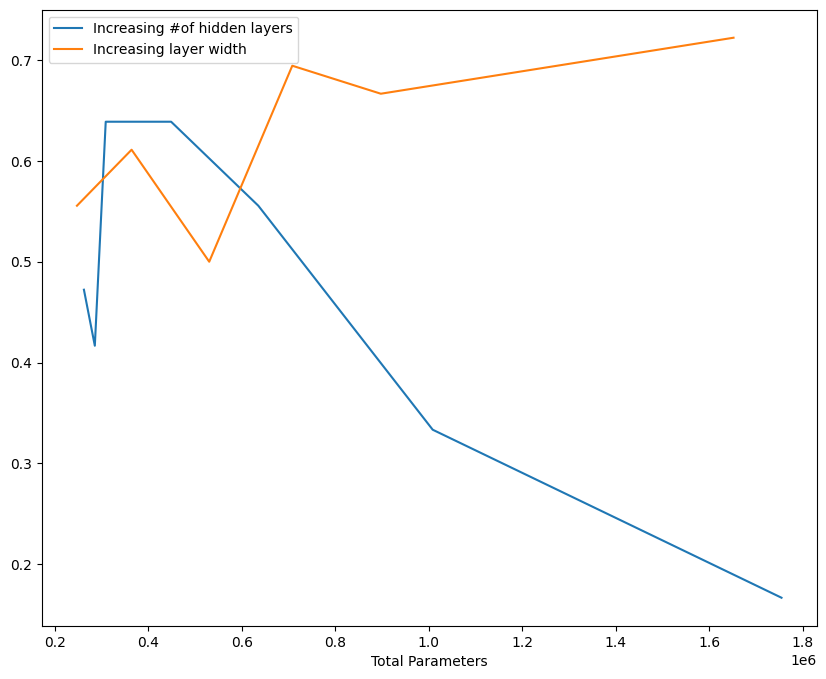

In [ ]:
results_df = pd.DataFrame(results, columns=['Accuracy', 'Total Parameters'])
results_model_size_df = pd.DataFrame(results_model_size, columns=['Accuracy', 'Total Parameters'])

fig, ax = plt.subplots(figsize=(10, 8))
results_df.plot(ax = ax, x='Total Parameters', y='Accuracy', kind='line', label='Increasing #of hidden layers')
results_model_size_df.plot(ax = ax, x='Total Parameters', y='Accuracy', kind='line', label='Increasing layer width')


In [ ]:
def dirichlet_energy(X, edge_index):
    # Compute the adjacency matrix.
    A = torch_geometric.utils.to_dense_adj(edge_index)
    # Compute the degree matrix.
    D = torch.diag(torch.sum(A, axis=1))
    # Compute the Laplacian matrix.
    L = D - A
    # Compute the Dirichlet energy.
    d_e = torch.matmul(torch.matmul(X.T, L), X).squeeze(0)
    d_e = torch.trace(d_e) # aggregate the feature space

    return d_e

### Plot Dirichlet Energy with and without norm in NN with 16 layers

In [ ]:
dirichlet_results = []
for norm in [nn.Identity, pyg_nn.PairNorm, pyg_nn.InstanceNorm, pyg_nn.LayerNorm]:
    model = RGCN(180, 16, len(dataset.data.edge_type.unique()), 16, norm=norm)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    # Train the model
    model.train()
    for epoch in range(50):
        optimizer.zero_grad()
        out,_ = model(data.x, data.edge_index, data.edge_type)
        loss = criterion(out[data.train_idx], data.train_y)
        print(f'Epoch: {epoch}, Loss: {loss:.4f}')
        loss.backward()
        optimizer.step()

    # Evaluate the model
    model.eval()
    pred,latents = model(data.x, data.edge_index, data.edge_type)
    correct = float(pred[data.test_idx].argmax(1).eq(data.test_y).sum().item())
    acc = correct / len(dataset.data.test_idx)
    total_params = sum(param.numel() for param in model.parameters())

    print(f'Test Accuracy: {acc:.4f}')

    # Compute the Dirichlet energy for each layer
    d_energies = np.array([dirichlet_energy(X, data.edge_index) for X in latents], np.float64)

    dirichlet_results.append((acc, d_energies))

/Users/moritzduck/miniconda3/envs/graphml/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch: 0, Loss: 24841010.0000
Epoch: 1, Loss: 14833605.0000
Epoch: 2, Loss: 16325235.0000
Epoch: 3, Loss: 9526515.0000
Epoch: 4, Loss: 12693844.0000
Epoch: 5, Loss: 5873077.5000
Epoch: 6, Loss: 8927234.0000
Epoch: 7, Loss: 4444946.5000
Epoch: 8, Loss: 3148354.2500
Epoch: 9, Loss: 2366803.2500
Epoch: 10, Loss: 10001151.0000
Epoch: 11, Loss: 3575091.2500
Epoch: 12, Loss: 4629458.5000
Epoch: 13, Loss: 3551041.0000
Epoch: 14, Loss: 2172268.2500
Epoch: 15, Loss: 2357492.7500
Epoch: 16, Loss: 1607788.2500
Epoch: 17, Loss: 1228130.0000
Epoch: 18, Loss: 2202005.5000
Epoch: 19, Loss: 1646997.2500
Epoch: 20, Loss: 1222497.1250
Epoch: 21, Loss: 1422292.6250
Epoch: 22, Loss: 1304048.0000
Epoch: 23, Loss: 1172550.2500
Epoch: 24, Loss: 1383462.7500
Epoch: 25, Loss: 1226984.6250
Epoch: 26, Loss: 582081.1875
Epoch: 27, Loss: 856810.7500
Epoch: 28, Loss: 831342.9375
Epoch: 29, Loss: 583168.1250
Epoch: 30, Loss: 1027230.0625
Epoch: 31, Loss: 683606.7500
Epoch: 32, Loss: 1118765.8750
Epoch: 33, Loss: 617

In [ ]:
dirichlet_results = [(0.4166666666666667,
  np.array([4.84284058e+09, 2.01999254e+13, 3.11208821e+13, 9.09123445e+13,
         6.61132117e+13, 8.10708715e+13, 3.81312196e+14, 2.74944563e+14,
         7.45269101e+14, 9.13611887e+14, 1.92732846e+15, 2.50499082e+15,
         2.45161297e+15, 3.46450933e+15, 7.98329784e+15, 2.25036143e+16,
         1.21558690e+17, 9.44788953e+16])),
 (0.3333333333333333,
  np.array([4.84284058e+09, 2.92428867e+13, 2.93683174e+13, 7.93596096e+08,
         8.30499648e+08, 5.61357248e+08, 3.19508640e+08, 5.29789088e+08,
         7.44674752e+08, 3.92699936e+08, 5.39064000e+08, 3.36982560e+08,
         3.62818464e+08, 8.07390656e+08, 1.80549216e+08, 4.39693952e+08,
         7.58717696e+08, 1.77295152e+08]))]

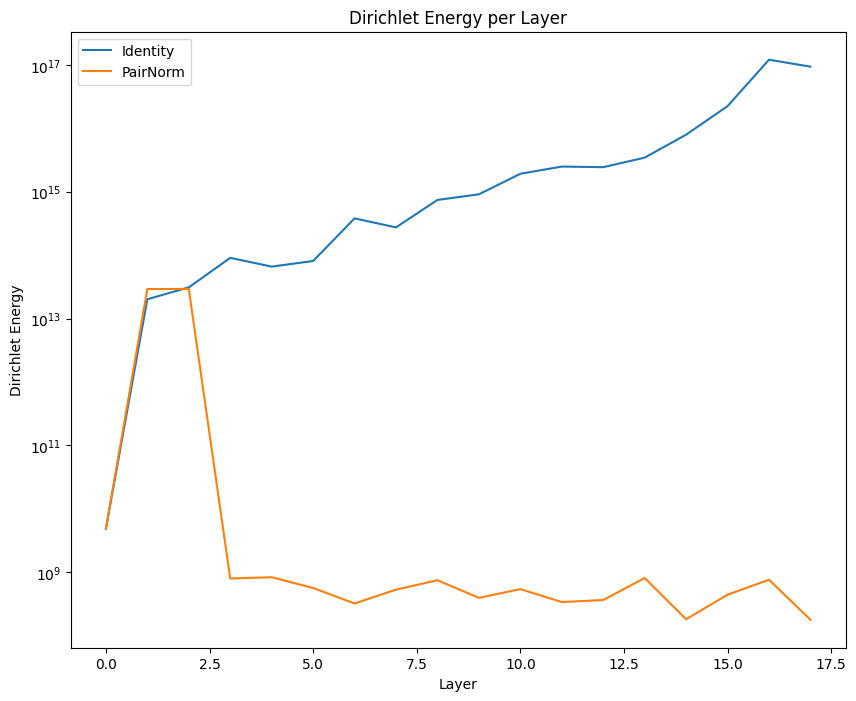

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_yscale('log')
ax.set_xlabel('Layer')
ax.set_ylabel('Dirichlet Energy')
ax.set_title('Dirichlet Energy per Layer')

for i,r in enumerate(dirichlet_results):
    x_values = list(range(len(r[1])))
    ax.plot(x_values, r[1])
    ax.legend(['Identity', 'PairNorm', 'InstanceNorm', 'LayerNorm'])
    

plt.show()